In [7]:
# Import all libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils
from keras.models import model_from_json
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disable warning message of tensorflow
import cv2
from numpy import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.measure import compare_ssim
import math

In [2]:
# Load X data
path1 = './Input/'
X_data = os.listdir(path1)
X_data = sorted(X_data)

X = np.array([np.array(cv2.resize(cv2.imread(path1 + img,0),(96,96), interpolation = cv2.INTER_CUBIC)).flatten() for img in X_data],'f')   
print(np.shape(X))

(25900, 9216)


In [3]:
# Load Y data
path2 = './Label/'
Y_data = os.listdir(path2)
Y_data = sorted(Y_data)

Y = np.array([np.array(cv2.resize(cv2.imread(path2 + img2,0),(96,96))).flatten() for img2 in Y_data],'f') 
print(np.shape(Y))

(25900, 9216)


In [4]:
# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state = 4)

X_train = X_train.reshape(X_train.shape[0], 96, 96, 1)
X_test = X_test.reshape(X_test.shape[0], 96, 96, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 96, 96, 1)
Y_test = Y_test.reshape(Y_test.shape[0], 96, 96, 1)

X_train = X_train.astype('int') 
X_test = X_test.astype('int')
Y_train = Y_train.astype('int') 
Y_test = Y_test.astype('int')

# Normalization of data 
# Data pixels are between 0 and 1
# X_train /= 255
# X_test /= 255
# Y_train /= 255
# Y_test /= 255

print(np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test))

(23310, 96, 96, 1) (2590, 96, 96, 1) (23310, 96, 96, 1) (2590, 96, 96, 1)


In [18]:
model = Sequential()
model.add(Conv2D(128, (9, 9), activation='relu', padding='same', kernel_initializer='glorot_uniform', use_bias=True, input_shape=(None, None, 1)))
model.add(Conv2D(64, (1, 1), activation='relu', padding='same', kernel_initializer='glorot_uniform', use_bias=True))
model.add(Conv2D(1, (5, 5), activation='linear', padding='same', kernel_initializer='glorot_uniform', use_bias=True))

opt = Adam(lr = 0.01)

model.compile(loss='mean_absolute_error', optimizer = opt, metrics=["accuracy"]) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 64)    8256      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 1)     1601      
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
_________________________________________________________________


In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.1, min_lr=0.00001)
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks = [EarlyStopping(monitor='loss', patience=3, verbose=1), reduce_lr, checkpoint]

results = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split = 0.1, shuffle = True, callbacks = callbacks)


Train on 20979 samples, validate on 2331 samples
Epoch 1/20
20979/20979 [==============================] - 52s 2ms/step - loss: 18.4834 - acc: 0.0502 - val_loss: 8.5943 - val_acc: 0.0623

Epoch 00001: loss improved from inf to 18.48344, saving model to weights.best.hdf5
Epoch 2/20
20979/20979 [==============================] - 53s 3ms/step - loss: 10.0756 - acc: 0.0553 - val_loss: 9.0504 - val_acc: 0.0529

Epoch 00002: loss improved from 18.48344 to 10.07558, saving model to weights.best.hdf5
Epoch 3/20
20979/20979 [==============================] - 53s 3ms/step - loss: 6.4452 - acc: 0.0793 - val_loss: 7.6338 - val_acc: 0.0593

Epoch 00003: loss improved from 10.07558 to 6.44519, saving model to weights.best.hdf5
Epoch 4/20
20979/20979 [==============================] - 53s 3ms/step - loss: 7.7404 - acc: 0.0630 - val_loss: 7.2357 - val_acc: 0.0614

Epoch 00004: loss did not improve from 6.44519
Epoch 5/20
20979/20979 [==============================] - 53s 3ms/step - loss: 5.6665 - acc:

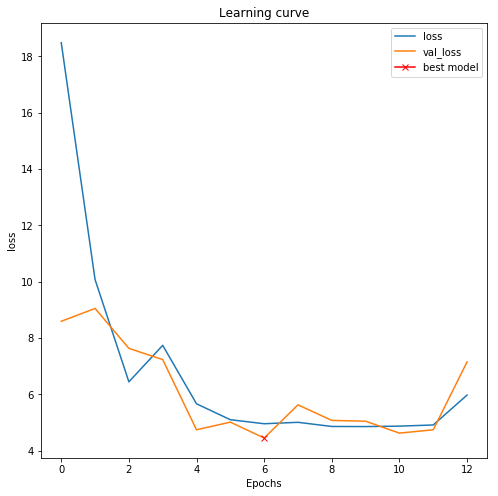

In [20]:
train_loss = results.history['loss']
val_loss = results.history['val_loss'] 
# train_acc = results.history['acc']
# val_acc = results.history['val_acc']

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [21]:
score = model.evaluate(X_test, Y_test, verbose=0) # accuracy check
print('Test loss:', score[0], 'Test accuracy:', score[1]) # Prints test accuracy

Test loss: 7.227268080545668 Test accuracy: 0.06997474606317904


In [22]:
# Save model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to H5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [36]:
# Load model and weights
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
# loaded_model.load_weights("weights.best.hdf5")
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


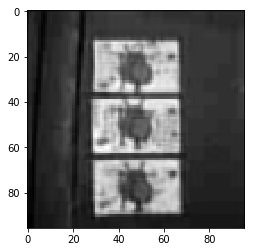

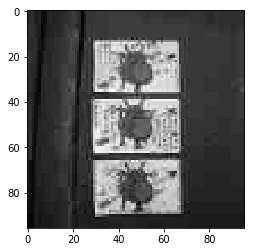

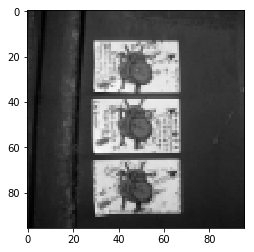

In [47]:
k = 0
test_img = X_test[k].reshape(1, 96, 96, 1)
pred_img = model.predict(test_img)
pred_img = pred_img.reshape(96,96)
pred_img = pred_img.astype('int') 
plt.imshow(pred_img, cmap='gray')
plt.figure()
plt.imshow(X_test[k].reshape(96,96), cmap='gray')
plt.figure()
plt.imshow(Y_test[k].reshape(96,96), cmap='gray')

Y_test_img = Y_test[k].reshape(96,96)
X_test_img = X_test[k].reshape(96,96)

In [48]:
# Compute MSE
print('MSE (Y, X): ', mean_squared_error(Y_test_img, X_test_img))
print('MSE (Y , Predict): ', mean_squared_error(Y_test_img, pred_img))

# Compute MAE
print('\nMAE (Y, X): ', mean_absolute_error(Y_test_img, X_test_img))
print('MAE (Y , Predict): ', mean_absolute_error(Y_test_img, pred_img))

# Compute SSIM
(score1, diff1) = compare_ssim(Y_test_img, X_test_img, full=True)
print('\nSSIM (Y, X): ', score1)
(score2, diff2) = compare_ssim(Y_test_img, pred_img, full=True)
print('SSIM (Y, Predict): ', score2)

MSE (Y, X):  78.9074435763889
MSE (Y , Predict):  94.21213107638887

MAE (Y, X):  5.711480034722221
MAE (Y , Predict):  6.307183159722221

SSIM (Y, X):  0.9999999999999937
SSIM (Y, Predict):  0.999999999999984


In [49]:
# Compute PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

psnr_X_test = psnr(Y_test_img, X_test_img)
print('\nPSNR (Y, X): ', psnr_X_test)
psnr_predict = psnr(Y_test_img, pred_img)
print('PSNR (Y, X): ', psnr_predict)


PSNR (Y, X):  29.159623874218465
PSNR (Y, X):  28.389735332307843


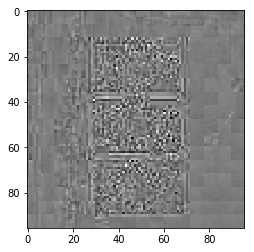

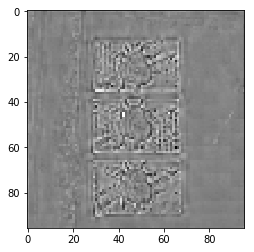

In [50]:
err_X_img = Y_test_img - X_test_img
plt.imshow(err_X_img, cmap='gray')

err_pred_img = Y_test_img - pred_img
plt.figure()
plt.imshow(err_pred_img, cmap='gray')